In [1]:
!pip install mplfinance

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 2.1 MB/s eta 0:00:00


In [2]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler
from sklearn.cluster import KMeans
import pandas as pd
import numpy as np
import mplfinance as mpf
from sklearn.decomposition import PCA

# Carregando os dados do arquivo Excel
file_path = '/content/Cópia de Challenge 3_NFLX.xlsx'
nflx_data = pd.read_excel(file_path, sheet_name='NFLX')
nflx_data['Date'] = pd.to_datetime(nflx_data['Date'])
nflx_data.set_index('Date', inplace=True)

# Selecionando as features 'Open', 'High', 'Low', 'Close'
features = nflx_data[['Open', 'High', 'Low', 'Close']]

nflx_data['High_Low_Diff'] = nflx_data['High'] - nflx_data['Low']  # Diferença entre High e Low
nflx_data['Pct_Change_Close_Open'] = ((nflx_data['Close'] - nflx_data['Open']) / nflx_data['Open']) * 100  # Variação porcentual
nflx_data['3_day_MA'] = nflx_data['Close'].rolling(window=3).mean()  # Média móvel de 3 dias
nflx_data['7_day_MA'] = nflx_data['Close'].rolling(window=7).mean()  # Média móvel de 7 dias

# Remover valores NaN resultantes do cálculo de médias móveis
nflx_data.dropna(inplace=True)

# Normalizando as features (tanto as features originais quanto as novas criadas)
scaler = RobustScaler()
features_to_scale = nflx_data[['Open', 'High', 'Low', 'Close', 'High_Low_Diff', 'Pct_Change_Close_Open', '3_day_MA', '7_day_MA']]

# Escalando as features
features_scaled = scaler.fit_transform(features_to_scale)

# Transformar o array escalado de volta para DataFrame usando as colunas corretas
features_scaled_df = pd.DataFrame(features_scaled, index=nflx_data.index, columns=features_to_scale.columns)

# Reduzindo para 2 componentes principais com PCA
pca = PCA(n_components=2)
pca_features = pca.fit_transform(features_scaled_df)

# Criando um DataFrame com as componentes principais
pca_data = pd.DataFrame(pca_features, index=nflx_data.index, columns=['PCA1', 'PCA2'])

# Verificando dados faltantes e duplicados
print(nflx_data.isnull().sum())  # Verificar dados faltantes no dataframe
print(f"Tamanho do nflx_data: {len(nflx_data)}")  # Tamanho do dataframe
duplicadas = nflx_data.duplicated().sum()
print(f"Linhas duplicadas: {duplicadas}")
nan_values = nflx_data.isnull().sum()
print(f"Valores NaN: {nan_values}")

# Verificar o número de linhas escaladas e no dataframe original
print(f"Tamanho do nflx_data: {nflx_data.shape[0]}")
print(f"Tamanho do features_scaled_df: {features_scaled_df.shape[0]}")

# Agora, features_scaled_df e nflx_data devem ter o mesmo tamanho


Open                     0
High                     0
Low                      0
Close                    0
High_Low_Diff            0
Pct_Change_Close_Open    0
3_day_MA                 0
7_day_MA                 0
dtype: int64
Tamanho do nflx_data: 5038
Linhas duplicadas: 0
Valores NaN: Open                     0
High                     0
Low                      0
Close                    0
High_Low_Diff            0
Pct_Change_Close_Open    0
3_day_MA                 0
7_day_MA                 0
dtype: int64
Tamanho do nflx_data: 5038
Tamanho do features_scaled_df: 5038


Silhouette Score com 2 clusters: 0.7146
Silhouette Score com 3 clusters: 0.6247
Silhouette Score com 4 clusters: 0.3456
Silhouette Score com 5 clusters: 0.4180
Silhouette Score com 6 clusters: 0.4241
Silhouette Score com 7 clusters: 0.4086
Silhouette Score com 8 clusters: 0.4014
Silhouette Score com 9 clusters: 0.3959
Silhouette Score com 10 clusters: 0.3910

Melhor número de clusters: 2 com Silhouette Score de 0.7146


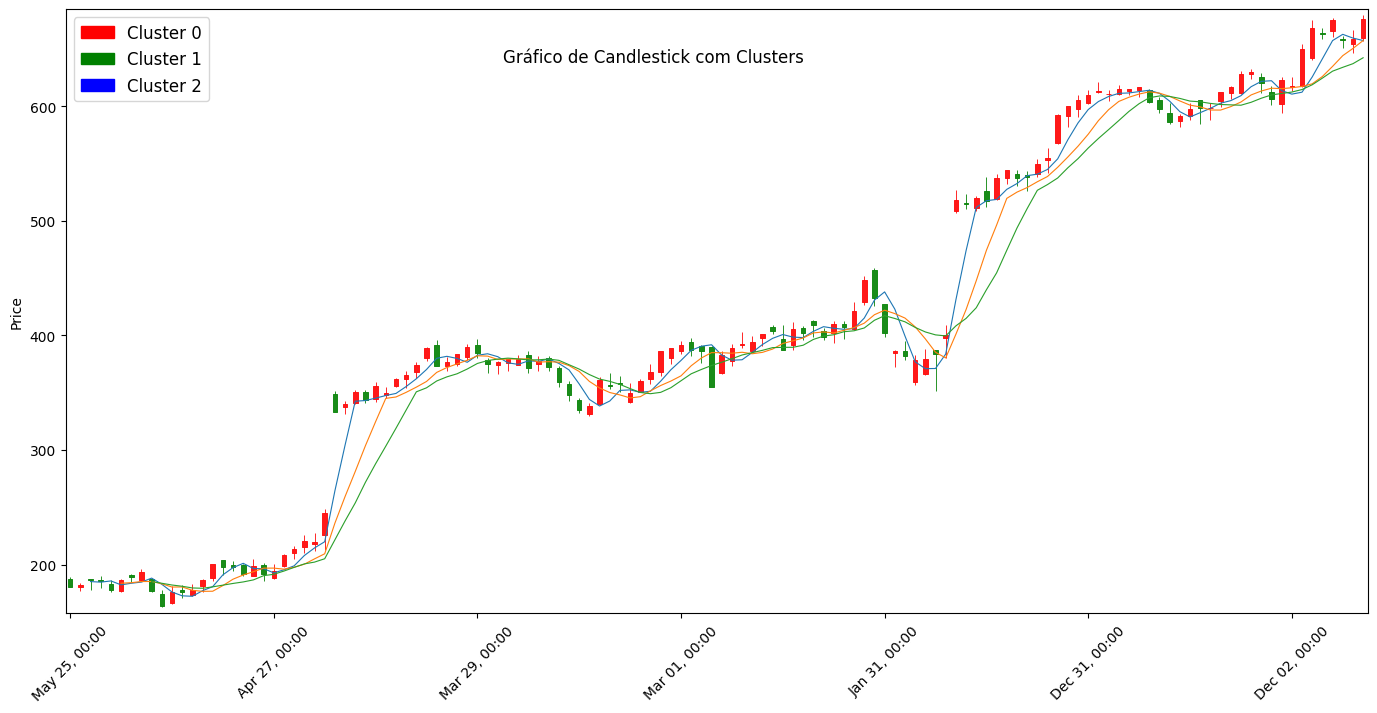

In [3]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import mplfinance as mpf

# Função para testar diferentes números de clusters e calcular o Silhouette Score
def testar_clusters_kmeans(X, max_clusters=10):
    melhor_score = -1
    melhor_n_clusters = 0
    melhor_modelo = None

    for n_clusters in range(2, max_clusters + 1):
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        clusters = kmeans.fit_predict(X)
        score = silhouette_score(X, clusters)
        print(f"Silhouette Score com {n_clusters} clusters: {score:.4f}")

        if score > melhor_score:
            melhor_score = score
            melhor_n_clusters = n_clusters
            melhor_modelo = kmeans

    print(f"\nMelhor número de clusters: {melhor_n_clusters} com Silhouette Score de {melhor_score:.4f}")

    # Retornar o melhor modelo e os clusters correspondentes
    return melhor_modelo, melhor_modelo.predict(X)

# Aplicar a função com os dados escalados
kmeans_melhor, clusters_kmeans_melhor = testar_clusters_kmeans(features_scaled)

# Adicionar os clusters ao dataframe original
nflx_data['Cluster_KMeans'] = clusters_kmeans_melhor

# Mapeando as cores dos clusters
cluster_colors = {0: 'red', 1: 'green', 2: 'blue'}

# Adicionando uma coluna de cor com base nos clusters
nflx_data['Color'] = nflx_data['Cluster_KMeans'].map(cluster_colors)

# Função para plotar o gráfico com a quantidade de velas selecionada e a legenda
def plot_candlestick_with_clusters(data, num_candles=50):
    # Selecionar o número de velas a serem exibidas
    visible_data = data.head(num_candles)

    # Convertendo as cores dos clusters para uma lista no formato aceito por mpf
    colors = visible_data['Color'].values.tolist()

    # Preparando o estilo de velas com cores personalizadas
    custom_style = mpf.make_marketcolors(up='green', down='red', edge='inherit', wick='inherit', volume='inherit')
    style = mpf.make_mpf_style(marketcolors=custom_style)

    # Criando o gráfico de candlestick
    fig, ax = mpf.plot(visible_data[['Open', 'High', 'Low', 'Close']],
                       type='candle', style=style,
                       mav=(3, 6, 9),  # Médias móveis
                       figsize=(15, 7),
                       title='Gráfico de Candlestick com Clusters',
                       tight_layout=True, returnfig=True)

    # Criando os handles para a legenda (definindo os patches com as cores e o rótulo do cluster)
    handles = [mpatches.Patch(color=color, label=f'Cluster {cluster}') for cluster, color in cluster_colors.items()]

    # Adicionando a legenda ao gráfico
    ax[0].legend(handles=handles, loc='upper left', fontsize=12)
    plt.show()

# Exemplo de uso da função com a quantidade de velas desejada
plot_candlestick_with_clusters(nflx_data, num_candles=128)


In [4]:
# Contar candles positivos (fechamento > abertura)
candles_positivos = len(nflx_data[nflx_data['Close'] > nflx_data['Open']])

# Contar candles negativos (fechamento < abertura)
candles_negativos = len(nflx_data[nflx_data['Close'] < nflx_data['Open']])

# Exibir os resultados
print(f"Quantidade de candles positivos: {candles_positivos}")
print(f"Quantidade de candles negativos: {candles_negativos}")


Quantidade de candles positivos: 2460
Quantidade de candles negativos: 2561


Digite a data de início (YYYY-MM-DD): 2021-07-01
Digite a data de fim (YYYY-MM-DD): 2021-07-30
Digite a quantidade de clusters que deseja aplicar: 2


<ipython-input-5-0f9c1ae281db>:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_periodo['color'] = df_periodo['Cluster_KMeans'].map(cluster_colors)
<ipython-input-5-0f9c1ae281db>:54: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(pad=2.0)


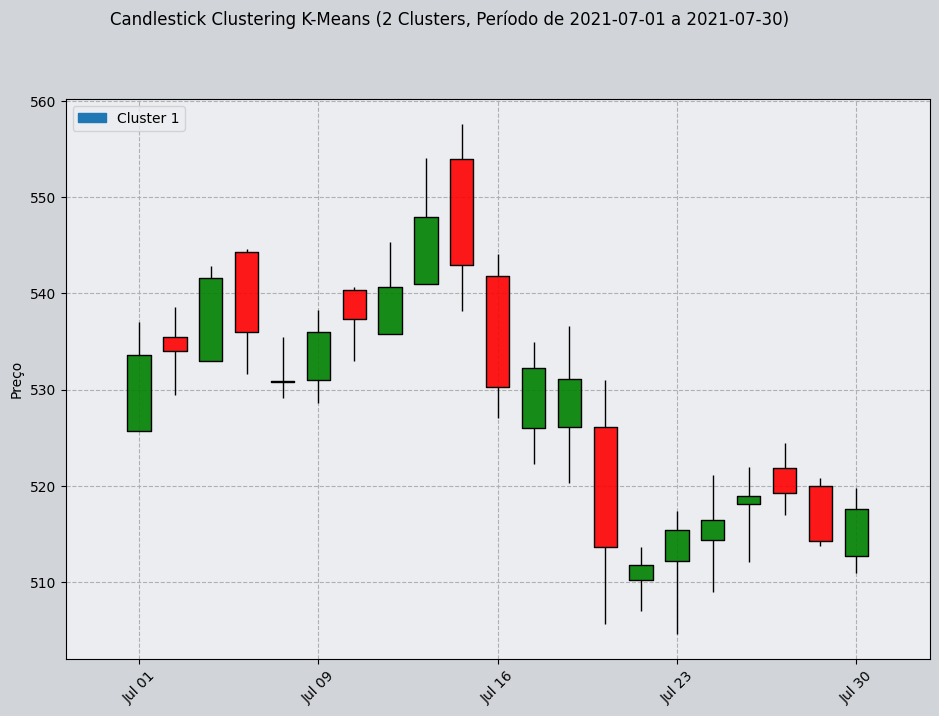

In [5]:
# Adiciona os clusters ao dataframe original
def aplicar_kmeans(nflx_data, num_clusters):
    # Normaliza as features e aplica o K-Means
    features = nflx_data[['Open', 'High', 'Low', 'Close', 'High_Low_Diff', 'Pct_Change_Close_Open', '3_day_MA', '7_day_MA']]
    scaler = RobustScaler()
    features_scaled = scaler.fit_transform(features)
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    clusters_kmeans = kmeans.fit_predict(features_scaled)

    # Adiciona os clusters ao DataFrame original
    nflx_data['Cluster_KMeans'] = clusters_kmeans
    return nflx_data

# Função para visualizar os clusters em gráficos de candlestick com entrada de período e número de clusters
def visualizar_clusters(nflx_data):
    # Solicita o período de visualização ao usuário
    data_inicio = input("Digite a data de início (YYYY-MM-DD): ")
    data_fim = input("Digite a data de fim (YYYY-MM-DD): ")

    # Solicita o número de clusters ao usuário
    num_clusters = int(input("Digite a quantidade de clusters que deseja aplicar: "))

    # Aplica o K-Means com o número de clusters escolhido
    nflx_data = aplicar_kmeans(nflx_data, num_clusters)

    # Filtra os dados pelo período especificado
    nflx_plot = nflx_data[['Open', 'High', 'Low', 'Close', 'Cluster_KMeans']].copy()
    nflx_plot.sort_index(inplace=True)
    df_periodo = nflx_plot.loc[data_inicio:data_fim]

    if df_periodo.empty:
        print(f"Não há dados disponíveis para o período de {data_inicio} a {data_fim}.")
    else:
        # Configura as cores dos clusters
        unique_clusters = df_periodo['Cluster_KMeans'].unique()
        cluster_colors = {cluster: plt.cm.tab20(i) for i, cluster in enumerate(unique_clusters)}
        df_periodo['color'] = df_periodo['Cluster_KMeans'].map(cluster_colors)

        # Configura as cores dos candles
        mc = mpf.make_marketcolors(up='green', down='red', wick='black', edge='black', volume='in')
        s = mpf.make_mpf_style(marketcolors=mc, gridstyle="--", figcolor="(0.82, 0.83, 0.85)", facecolor="(0.92, 0.93, 0.94)")

        # Cria o gráfico de candlestick
        fig, axlist = mpf.plot(df_periodo, type='candle', style=s, ylabel='Preço',
                               title=f'Candlestick Clustering K-Means ({num_clusters} Clusters, Período de {data_inicio} a {data_fim})',
                               volume=False, show_nontrading=False,
                               figsize=(12, 8), returnfig=True)

        # Adiciona a legenda para os clusters
        handles = [mpatches.Patch(color=color, label=f'Cluster {cluster}') for cluster, color in cluster_colors.items()]
        axlist[0].legend(handles=handles, loc='upper left', fontsize=10)

        # Ajusta o layout
        fig.tight_layout(pad=2.0)
        plt.show()

# Executa a visualização dos clusters
visualizar_clusters(nflx_data)
